## Balls Classification based on pretrained residual network using transfer learning

In [1]:
import torch 
from torchvision import models
import torchvision 
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfm
from tqdm import tqdm
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
import numpy as np 

%matplotlib inline 

In [2]:
# this is the mean and std for ImageNet dataset
Mean = np.asarray([ 0.485, 0.456, 0.406 ])
Std = np.asarray([ 0.229, 0.224, 0.225 ])

In [3]:
train_tfms = tfm.Compose([tfm.RandomCrop(224, padding=4, padding_mode='reflect'), 
                         tfm.RandomHorizontalFlip(0.5),                          
                         tfm.RandomVerticalFlip(0.6),
                         tfm.ToTensor(), 
                         tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
                         tfm.Lambda(lambda x: x.mul(255.))
                         ])
test_tfms = tfm.Compose([
    tfm.ToTensor(),
    tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
])

In [4]:
from PIL import Image

load_tfms = tfm.Compose([
    tfm.Resize((224,224)), 
    tfm.ToTensor(),
    tfm.Normalize(Mean, Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
    ])

def loadPicture(path):    
    image = Image.open(path).convert('RGB')    
    img=load_tfms(image)    
    plt.imshow(image)
    return img 

In [5]:
def showTensorImage(image):
    tfm=transforms.Compose([
        # reverse the normalization
        transforms.Lambda(lambda x: x.div(255.) ), 
        transforms.Normalize((-1 * Mean / Std), (1.0 / Std),inplace=True) 
        ])
    img=tfm(image)
    plt.figure(figsize=(10,10) )
    plt.imshow(img.permute(1,2,0))

In [6]:
root="balls"

trainDS=ImageFolder(f'{root}/train', transform=train_tfms)
valDS=ImageFolder(f'{root}/valid', transform=train_tfms)
testDS=ImageFolder(f'{root}/test', transform=test_tfms)
print(f'train ds has {len(trainDS)},  val ds has {len(valDS) } and testDS has {len(testDS)} items with {len(trainDS.classes)} classes')
img, _=trainDS[1]
print(img.shape)

train ds has 2860,  val ds has 120 and testDS has 120 items with 24 classes
torch.Size([3, 224, 224])


### Let's look at some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


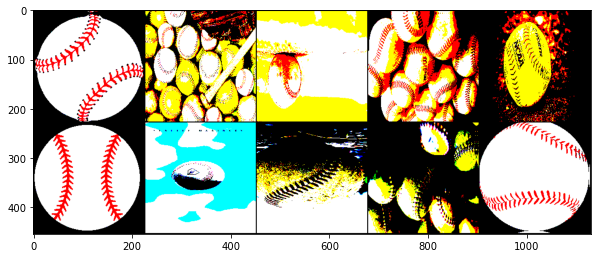

In [7]:
from torchvision.utils import make_grid
num_images=10
images = [trainDS[idx][0] for idx in range(num_images)]
plt.figure(figsize=(10,10) )

image_grid = make_grid(images, nrow=num_images//2)            
plt.imshow(image_grid.permute(1, 2, 0).squeeze(0))    


In [8]:
def getDataLoaders(batchSize):
    trainldr=DataLoader(trainDS, shuffle=True, num_workers=4, pin_memory=True, batch_size=batchSize ) 
    valldr=DataLoader(valDS, num_workers=4, pin_memory=True, batch_size=batchSize)
    testldr=DataLoader(testDS,num_workers=4, pin_memory=True, batch_size=batchSize)

    return trainldr, valldr, testldr 

## Import the resnet model from model zoo
Transfer learning has 2 modes: 
1. fine tuning: weights are not frozen abd pretrained model is used as starting point to train for custom data
2. feature extractor: weights are frozen. only final linear is trained

In [9]:
def getModel(ntwkType=0, frozen=True):
    model=None 
    
    if ntwkType==0:
        model=models.resnet18(pretrained=True)        
    elif ntwkType==1:        
        model=models.resnet34(pretrained=True)
    elif ntwkType==2:
        model=models.resnet50(pretrained=True)
    elif ntwkType==3:
        model=models.resnet101(pretrained=True)
    elif ntwkType==4:
        model=models.resnet152(pretrained=True)        
        
    inputs=model.fc.in_features
    if frozen:        
        for param in model.parameters():
            param.requires_grad=False
    model.fc=torch.nn.Linear(inputs, len(trainDS.classes) )
    return model 


In [10]:
model=getModel(0,False)
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def getAccuracy(outputs, labels):
    preds=torch.argmax(outputs, dim=1)
    return torch.sum(preds==labels).item()

In [13]:
import torch.nn.functional as F  

def train(ldr, opt, sched=None):    
    num_items=0
    losses=0.
    accs=0.
    model.train()
    for batch in tqdm(ldr):        
        opt.zero_grad()        
        imgs, lbls=batch 
        num_items+=len(lbls)
        imgs=imgs.to(device)
        lbls=lbls.to(device)
        outputs=model(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
        loss.backward()        
        opt.step()
        if sched is not None:
            sched.step()
    return losses/num_items, accs/num_items 


In [14]:
def evaluate(ldr, trainedModel):
    size=0
    losses=0. 
    accs=0. 
    trainedModel.eval()
    for batch in tqdm(ldr):
        imgs, lbls=batch 
        size+=len(lbls)
        imgs=imgs.to(device )
        lbls=lbls.to(device )
        outputs=trainedModel(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
    return losses/size , accs/size 

In [15]:
import torch.optim as optim 

batchsize=256
lr=1e-4
epochs=10

opt=optim.Adam(model.parameters(), lr=lr)
trainLdr, valLdr, testLdr =getDataLoaders(batchsize)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=lr*2., epochs=epochs,steps_per_epoch=len(trainLdr))

In [16]:
import  IPython.display as display 

def showResults(tloss, tacc, vloss, vacc):
    display.clear_output(wait=True )
    print('epoch\t TLosses\t TAccs\t\t VLosses\t VAccs')
    print('------------------------------------------------------------')
    for i in range(len(tloss)):
        print(f'{i+1}\t {tloss[i]:.3f}\t\t {tacc[i]*100.:.3f}% \t {vloss[i]:.3f}\t\t {vacc[i]*100.:.3f}%')

In [17]:
trainLosses=[]
trainAccs=[]
valLosses=[]
valAccs=[]
curValAcc=0.

for ep in range(epochs):
    print(f'\nTraining {ep+1}/{epochs}')
    losses, accs=train(trainLdr, opt, sched)
    trainLosses+=[losses]
    trainAccs+=[accs]
    print(f'Validating {ep+1}/{epochs}')
    losses, accs=evaluate(valLdr, model)
    valLosses+=[losses]
    valAccs+=[accs]
    if accs>curValAcc and ep>5:
        torch.save(model, 'trained.pth')
        curValAcc=accs
    showResults(trainLosses, trainAccs, valLosses, valAccs)

epoch	 TLosses	 TAccs		 VLosses	 VAccs
------------------------------------------------------------
1	 3.272		 8.636% 	 2.685		 25.833%
2	 1.869		 60.524% 	 0.809		 84.167%
3	 0.560		 91.049% 	 0.192		 97.500%
4	 0.211		 96.294% 	 0.120		 96.667%
5	 0.114		 98.042% 	 0.073		 99.167%
6	 0.076		 98.951% 	 0.058		 99.167%
7	 0.052		 99.580% 	 0.043		 98.333%
8	 0.041		 99.755% 	 0.042		 99.167%
9	 0.036		 99.930% 	 0.036		 99.167%
10	 0.036		 99.790% 	 0.033		 99.167%


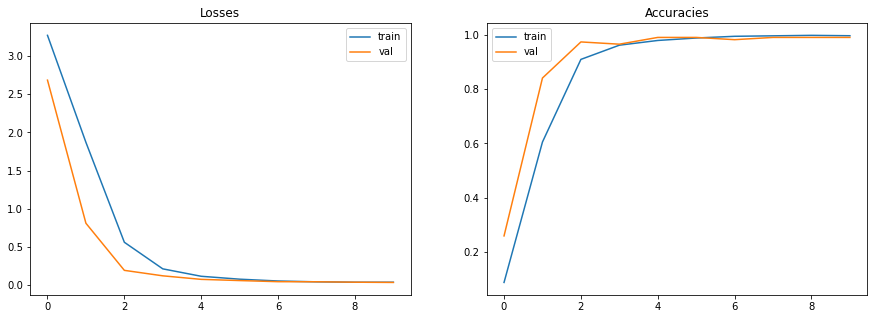

In [18]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(trainLosses, label='train')
plt.plot(valLosses, label='val')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Accuracies')
plt.plot(trainAccs, label='train')
plt.plot(valAccs, label='val')
plt.legend()

plt.show()

## load the best performing weights from training

In [19]:
model2=torch.load('trained.pth')
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
losses, accs=evaluate(testLdr,model2)
print(f'Test Losses={losses:.3f}, accuracies={accs*100. : .2f} % ')

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Test Losses=0.062, accuracies= 98.33 % 


## Inferencing with images containing various fruits

iimg shape: torch.Size([3, 224, 224]) 


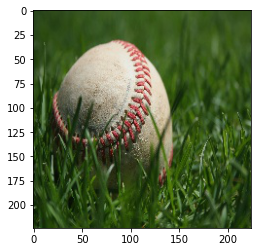

In [21]:
img='3.jpg'
path=f'{root}/{img}'
img=loadPicture(path)
print(f'iimg shape: {img.shape} ')

In [22]:
def detectObject(img, model):
    img=img.to(device)
    output=model(img.unsqueeze(0) )
    output=F.softmax(output, dim=1)
    prob, id=torch.max(output, dim=1)    
    return prob.to('cpu') , id.to('cpu')

In [23]:
print(img.shape)
prob, id=detectObject(img,model2)
prob=prob.detach().numpy()
print(f'detected {trainDS.classes[id] } to {prob[0]*100. :.2f}%  ')

torch.Size([3, 224, 224])
detected baseball to 99.49%  
